# ネットワークモチーフ解析
大腸菌の遺伝子制御ネットワークを例にして，ネットワークモチーフ解析を行います。 + ネットワークモチーフを見つける。 + 部分ネットワーク・プロファイルを計算する。

# ネットワークモチーフを見つける

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import itertools

import matplotlib.pyplot as plt

/Users/koga/.pyenv/versions/3.8.9/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## 大腸菌の遺伝子制御ネットワークの読み込み

* `../data/ecoli_regDB5.txt`
* エッジリスト形式
* Salgado H et al. (2006) RegulonDB (version 5.0): Escherichia coli K-12 transcriptional regulatory network, operon organization, and growth conditions. Nucleic Acids Res., 34, pp. D394–D397. https://doi.org/10.1093/nar/gkj156


In [4]:

d = pd.read_csv("../data/ecoli_regDB5.txt", header=None,names=["source", "target"], sep="\t| ", engine='python')
g = nx.from_pandas_edgelist(d, edge_attr=None, create_using=nx.DiGraph())
Gcc = sorted(nx.weakly_connected_components(g), key=len, reverse=True)
G = g.subgraph(Gcc[0])

## 現実のネットワークの3ノードで構成される部分ネットワークの出現頻度を計算

In [5]:
# TODO: fix hard coding
motifs_3 = {
    'S1': nx.DiGraph([(2,1),(2,3)]),
    'S2': nx.DiGraph([(2,1),(3,2)]),
    'S3': nx.DiGraph([(2,1),(2,3), (3,2)]),
    'S4': nx.DiGraph([(2,1), (3,2)]),
    'S5': nx.DiGraph([(2,1),(3,1),(2,3)]),
    'S6': nx.DiGraph([(2,1),(3,1),(2,3),(3,2)]),
    'S7': nx.DiGraph([(1,2),(2,3),(3,2)]),
    'S8': nx.DiGraph([(1,2),(2,1),(2,3), (3,2)]),
    'S9': nx.DiGraph([(1,2),(2,3),(3,1)]),
    'S10': nx.DiGraph([(1,2),(2,1),(2,3),(3,1)]),
    'S11': nx.DiGraph([(1,2),(2,1),(3,1),(3,2)]),
    'S12': nx.DiGraph([(1,2),(2,1),(2,3),(3,1),(3,2)]),
    'S13': nx.DiGraph([(1,2),(2,1),(2,1),(2,3),(3,1),(3,2)]),
    }

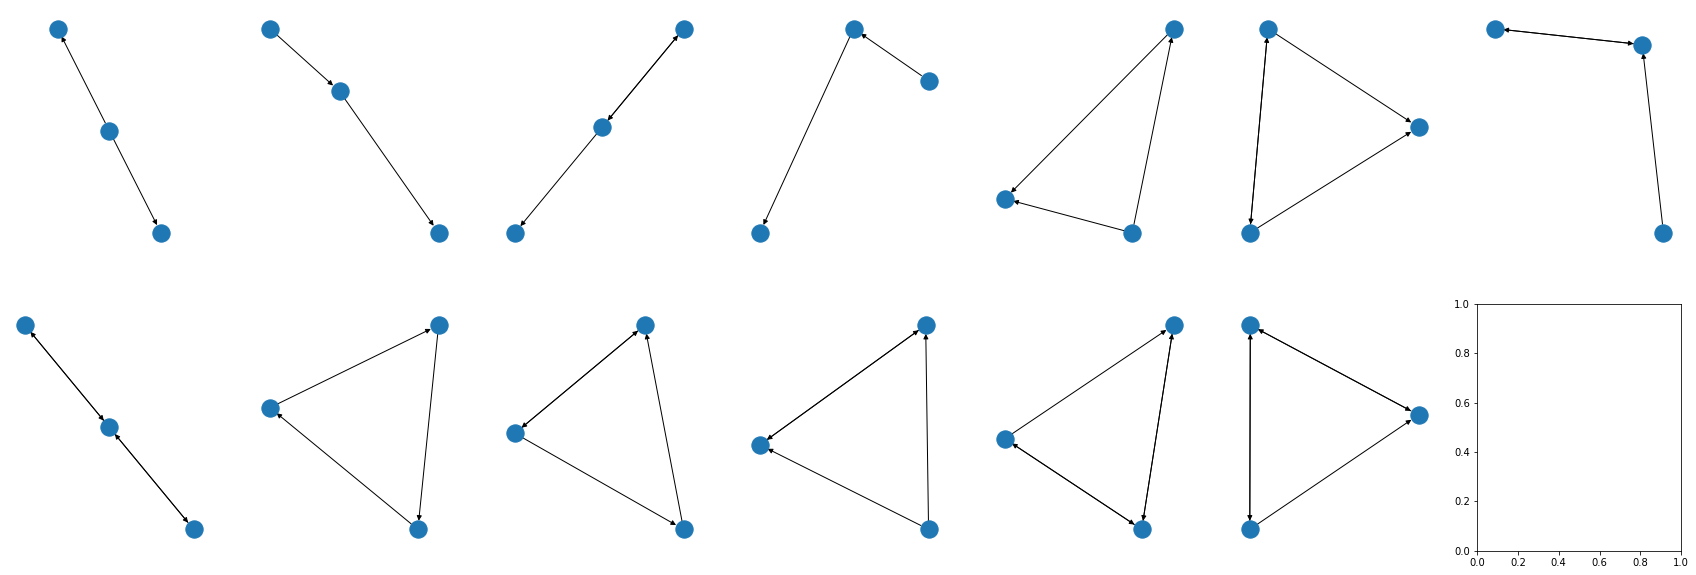

In [6]:
fig, ax = plt.subplots(2, 7, figsize=(30, 10))
for i in range(13):
    nx.draw(motifs_3[f"S{i+1}"], ax=ax[int(i/7)][i%7])

In [29]:

# https://gist.github.com/tpoisot/8582648
def mcounter(gr, mo):
    """Counts motifs in a directed graph
    :param gr: A ``DiGraph`` object
    :param mo: A ``dict`` of motifs to count
    :returns: A ``dict`` with the number of each motifs, with the same keys as ``mo``
    This function is actually rather simple. It will extract all 3-grams from
    the original graph, and look for isomorphisms in the motifs contained
    in a dictionary. The returned object is a ``dict`` with the number of
    times each motif was found.::
        >>> print mcounter(gr, mo)
        {'S1': 4, 'S3': 0, 'S2': 1, 'S5': 0, 'S4': 3}
    """
    #This function will take each possible subgraphs of gr of size 3, then
    #compare them to the mo dict using .subgraph() and is_isomorphic
    
    #This line simply creates a dictionary with 0 for all values, and the
    #motif names as keys

    mcount = dict(zip(mo.keys(), list(map(int, np.zeros(len(mo))))))
    nodes = gr.nodes()

    #We use iterools.product to have all combinations of three nodes in the
    #original graph. Then we filter combinations with non-unique nodes, because
    #the motifs do not account for self-consumption.

    triplets = list(itertools.product(*[nodes, nodes, nodes]))
    triplets = [trip for trip in triplets if len(list(set(trip))) == 3]
    triplets = map(list, map(np.sort, triplets))
    u_triplets = []
    [u_triplets.append(trip) for trip in triplets if not u_triplets.count(trip)]

    #The for each each of the triplets, we (i) take its subgraph, and compare
    #it to all fo the possible motifs

    for trip in u_triplets:
        sub_gr = gr.subgraph(trip)
        mot_match = map(lambda mot_id: nx.is_isomorphic(sub_gr, mo[mot_id]), motifs.keys())
        match_keys = [mo.keys()[i] for i in xrange(len(mo)) if mot_match[i]]
        if len(match_keys) == 1:
            mcount[match_keys[0]] += 1

    return mcount

In [11]:
mcount = dict(zip(motifs_3.keys(), list(map(int, np.zeros(len(motifs_3))))))

In [ ]:
nodes = G.nodes()

In [14]:
triplets = list(itertools.product(*[nodes, nodes, nodes]))

In [ ]:
triplets

## 100個のランダムネットワークの3ノード部分ネットワークの出現頻度を計算

In [2]:
motifs_3.keys()


NameError: name 'motifs_3' is not defined

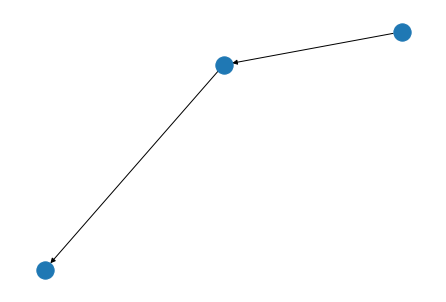

In [44]:
nx.draw(nx.path_graph(3, create_using=nx.DiGraph()))